In [1]:
#%pip install scipy==1.11.4

In [2]:
import pandas as pd
import numpy as np
import os
import pickle

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import export_graphviz

from functions.missclassification_rate import missclassification_rate
from functions.extract_original_feature_name import extract_original

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data and model imports

In [4]:
path = os.getcwd() + '/data'
X_test = pd.read_csv(path + '/X_test.csv')
y_test = pd.read_csv(path + '/y_test.csv')
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')

# Evaluation

## Initialization of lists for results table

In [5]:
model_name_result = ['Logistic Regression (undersample)', 'Logistic Regression (oversample)', 'Random forest (undersample)', 'Random forest (oversample)',
         'XGB (undersample)', 'XGB (oversample)', 'LGB (undersample)', 'LGB (oversample)']
recall_result = []
precision_result = []
f1_result = []
acc_result = []
ks_result = []
roc_auc_result = []
pr_auc_result = []
miss_rate_result = []
acc_diff_result = []
recall_diff_result = []
fn_cnt = []

## Logistic Regression

In [6]:
with open('models/under_lr.pkl', 'rb') as f:
    u_lr = pickle.load(f)
f.close()

with open('models/over_lr.pkl', 'rb') as f:
    o_lr = pickle.load(f)
f.close()

### Predictions

In [7]:
lr_under_y_pred = u_lr.predict(X_test)
lr_over_y_pred = o_lr.predict(X_test)

lr_under_y_pred_proba = u_lr.predict_proba(X_test)
lr_over_y_pred_proba =o_lr.predict_proba(X_test)

under_train_pred = u_lr.predict(X_train)
over_train_pred = o_lr.predict(X_train)
under_train_pred_proba = u_lr.predict_proba(X_train)
over_train_pred_proba = o_lr.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_7545/2786963175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


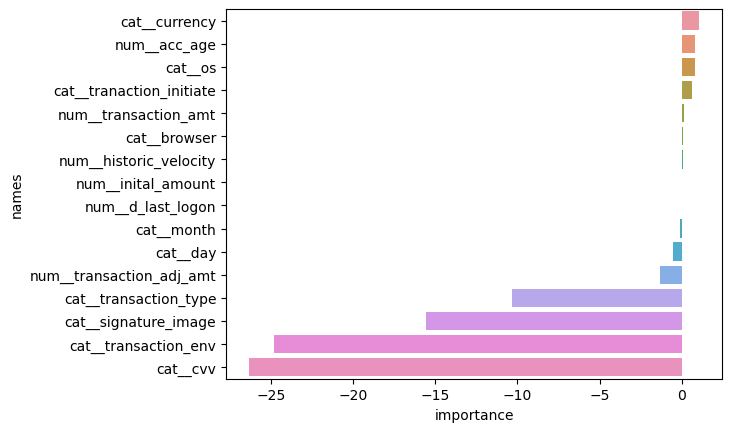

                       names  importance
1              cat__currency    1.080663
10              num__acc_age    0.806515
5                    cat__os    0.798002
7   cat__tranaction_initiate    0.617734
15      num__transaction_amt    0.124260
0               cat__browser    0.083908
12    num__historic_velocity    0.067227
13        num__inital_amount    0.005073
11         num__d_last_logon   -0.012559
4                 cat__month   -0.124436
3                   cat__day   -0.519698
14  num__transaction_adj_amt   -1.315766
9      cat__transaction_type  -10.333541
6       cat__signature_image  -15.535659
8       cat__transaction_env  -24.798368
2                   cat__cvv  -26.351527


In [8]:
coef = list(u_lr.best_estimator_.named_steps['LogReg'].coef_)
f_names = list(u_lr.best_estimator_[:-1].get_feature_names_out())
imp_temp  = pd.DataFrame({'names': f_names, 'importance': coef[0]}).sort_values(by='importance', ascending=False)

cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_7545/1410451271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


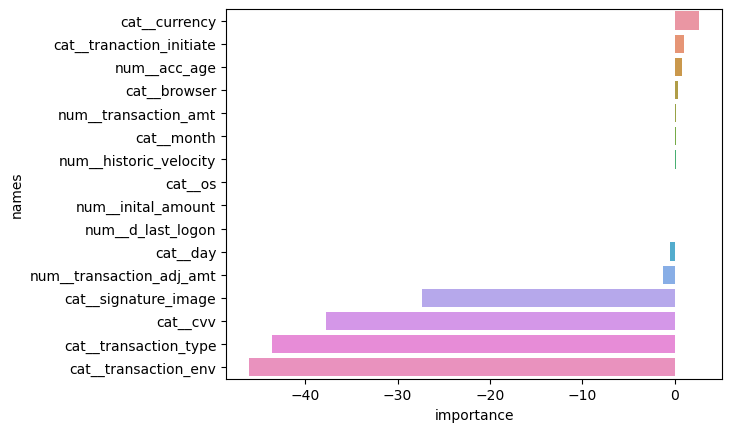

                       names  importance
1              cat__currency    2.662192
7   cat__tranaction_initiate    0.935961
10              num__acc_age    0.820399
0               cat__browser    0.345160
15      num__transaction_amt    0.122196
4                 cat__month    0.099576
12    num__historic_velocity    0.072276
5                    cat__os    0.048950
13        num__inital_amount   -0.009583
11         num__d_last_logon   -0.021379
3                   cat__day   -0.574078
14  num__transaction_adj_amt   -1.327185
6       cat__signature_image  -27.365476
2                   cat__cvv  -37.804001
9      cat__transaction_type  -43.601153
8       cat__transaction_env  -46.135974


In [9]:
coef = list(o_lr.best_estimator_.named_steps['LogReg'].coef_)
f_names = list(o_lr.best_estimator_[:-1].get_feature_names_out())
imp_temp  = pd.DataFrame({'names': f_names, 'importance': coef[0]}).sort_values(by='importance', ascending=False)

cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [10]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}, loc: {ks.statistic_location}")
loc_under_lr = ks.statistic_location
ks_result.append(ks.statistic)

0.7641 p-value: 0.000e+00, loc: 0.5089305627220164


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


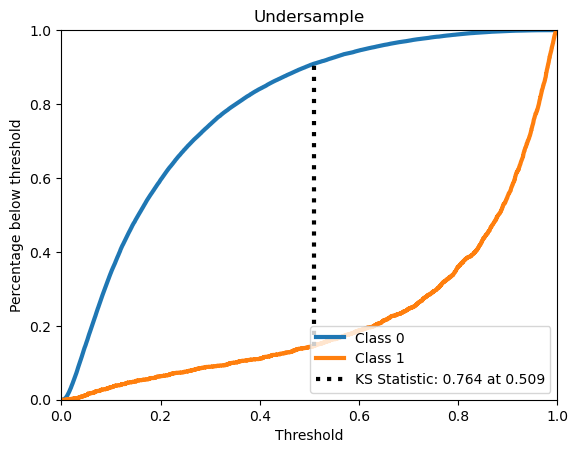

In [11]:
skplt.metrics.plot_ks_statistic(y_test, lr_under_y_pred_proba, title='Undersample')
plt.show()

In [12]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")
loc_over_lr = ks.statistic_location
ks_result.append(ks.statistic)



0.7708 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


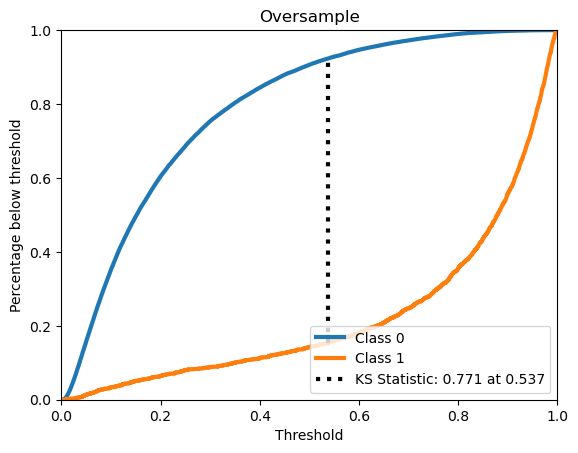

In [13]:
skplt.metrics.plot_ks_statistic(y_test, lr_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [14]:
lr_under_cut_off = loc_under_lr
lr_over_cut_off = loc_over_lr
lr_over_y_pred_proba_class = np.where(lr_over_y_pred_proba[:, 1] > lr_under_cut_off, 1, 0)
lr_under_y_pred_proba_class = np.where(lr_under_y_pred_proba[:, 1] > lr_over_cut_off, 1, 0)

### Precision-Recall Curve

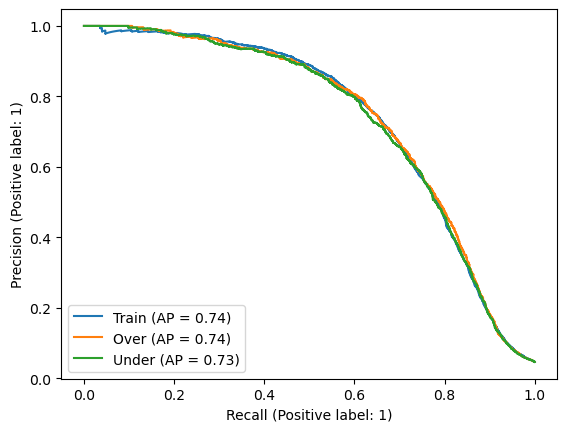

In [15]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

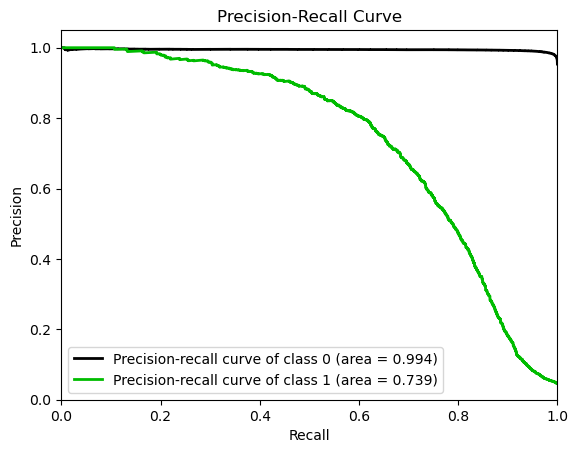

In [16]:
skplt.metrics.plot_precision_recall(y_test, lr_over_y_pred_proba, plot_micro=False)

### Confussion matrix

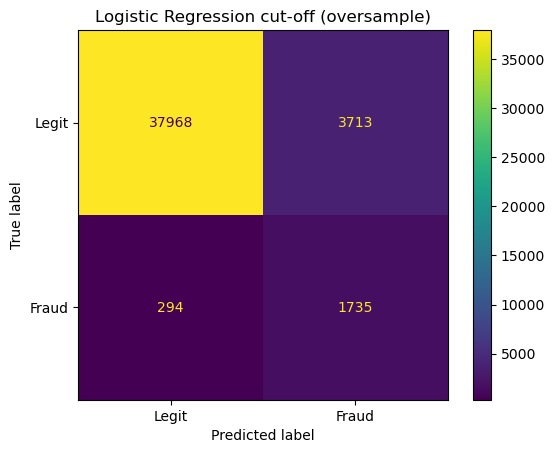

In [17]:
lr_cm_over = confusion_matrix(y_test, lr_over_y_pred_proba_class)
lr_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm_over, display_labels = ['Legit', 'Fraud'])
lr_cm_over_display.plot()
plt.title('Logistic Regression cut-off (oversample)')
plt.show()

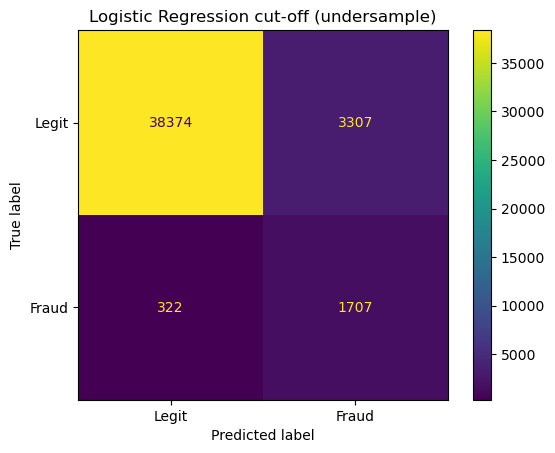

In [18]:
lr_cm_under = confusion_matrix(y_test, lr_under_y_pred_proba_class)
lr_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm_under, display_labels = ['Legit', 'Fraud'])
lr_cm_under_display.plot()
plt.title('Logistic Regression cut-off (undersample)')
plt.show()

In [19]:
fn_cnt.append((lr_cm_under[1][0]))
fn_cnt.append((lr_cm_over[1][0]))

### Cumulative Gain

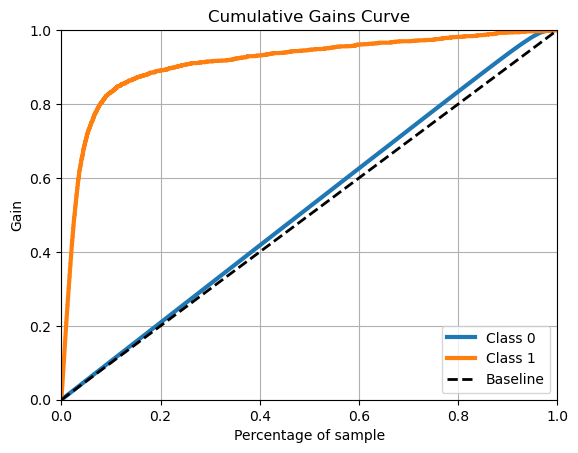

In [20]:
skplt.metrics.plot_cumulative_gain(y_test, lr_over_y_pred_proba)
plt.show()

### ROC

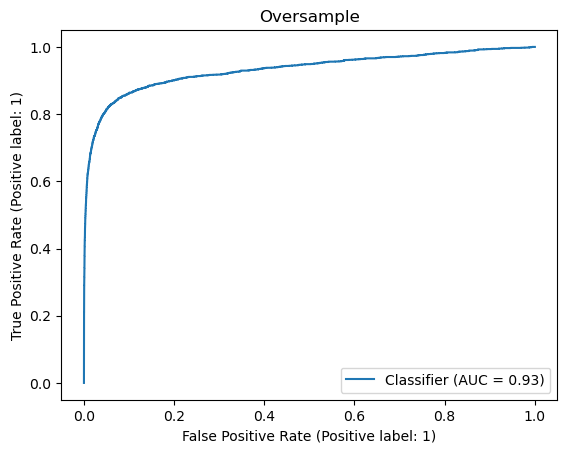

In [21]:
RocCurveDisplay.from_predictions(
    y_test, lr_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [22]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lr_over_y_pred_proba_class)}')

Accuracy Train: 0.9008706906694905 Test: 0.9083276138183483


In [23]:
print(classification_report(y_test, lr_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     41681
           1       0.32      0.86      0.46      2029

    accuracy                           0.91     43710
   macro avg       0.66      0.88      0.71     43710
weighted avg       0.96      0.91      0.93     43710



In [24]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lr_over_y_pred)}')

The missclasification rate is: 0.09592770533058796


# Random Forest

In [25]:
with open('models/under_rf.pkl', 'rb') as f:
    u_rf = pickle.load(f)
f.close()

with open('models/over_rf.pkl', 'rb') as f:
    o_rf = pickle.load(f)
f.close()

### Predictions

In [26]:
rf_under_y_pred = u_rf.predict(X_test)
rf_over_y_pred = o_rf.predict(X_test)

rf_under_y_pred_proba = u_rf.predict_proba(X_test)
rf_over_y_pred_proba =o_rf.predict_proba(X_test)

under_train_pred = u_rf.predict(X_train)
over_train_pred = o_rf.predict(X_train)
under_train_pred_proba = u_rf.predict_proba(X_train)
over_train_pred_proba = o_rf.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categ

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_7545/167288925.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


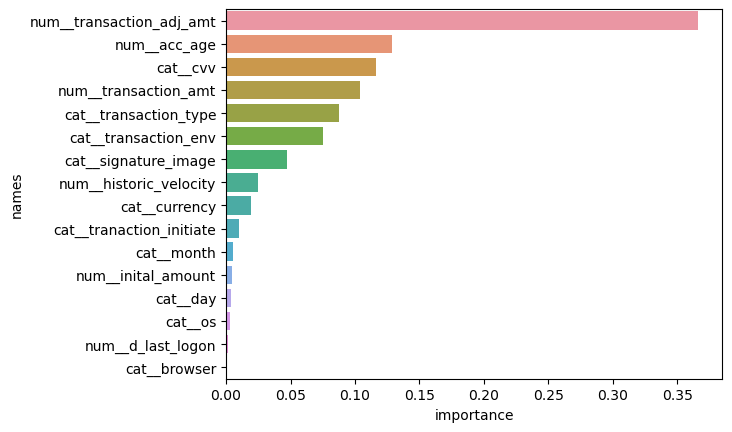

                       names  importance
14  num__transaction_adj_amt    0.366337
10              num__acc_age    0.128683
2                   cat__cvv    0.116403
15      num__transaction_amt    0.103750
9      cat__transaction_type    0.087599
8       cat__transaction_env    0.075257
6       cat__signature_image    0.047151
12    num__historic_velocity    0.025028
1              cat__currency    0.019615
7   cat__tranaction_initiate    0.010167
4                 cat__month    0.005573
13        num__inital_amount    0.005001
3                   cat__day    0.004067
5                    cat__os    0.002943
11         num__d_last_logon    0.001691
0               cat__browser    0.000734


In [27]:
importances = list(u_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(u_rf.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_7545/45559779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


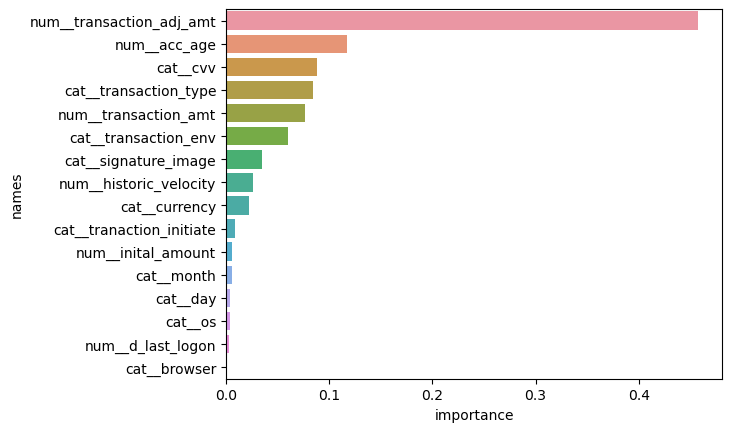

                       names  importance
14  num__transaction_adj_amt    0.457881
10              num__acc_age    0.116830
2                   cat__cvv    0.088603
9      cat__transaction_type    0.084474
15      num__transaction_amt    0.076965
8       cat__transaction_env    0.059698
6       cat__signature_image    0.034924
12    num__historic_velocity    0.026616
1              cat__currency    0.022104
7   cat__tranaction_initiate    0.008970
13        num__inital_amount    0.005911
4                 cat__month    0.005786
3                   cat__day    0.004102
5                    cat__os    0.003745
11         num__d_last_logon    0.002479
0               cat__browser    0.000912


In [28]:
importances = list(o_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(o_rf.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [29]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}, loc: {ks.statistic_location}")
loc_under_rf = ks.statistic_location
ks_result.append(ks.statistic)

0.7594 p-value: 0.000e+00, loc: 0.48484617419285914


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


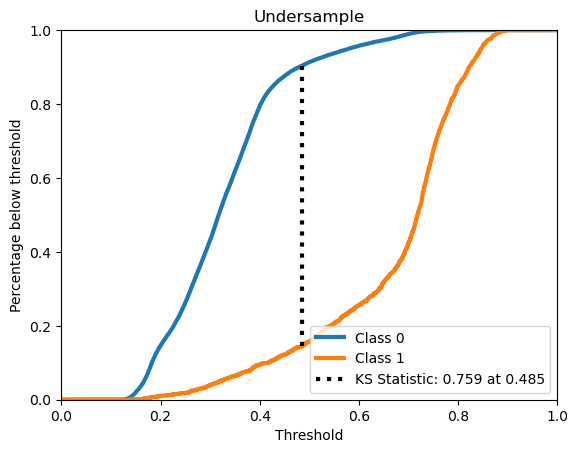

In [30]:
skplt.metrics.plot_ks_statistic(y_test, rf_under_y_pred_proba, title='Undersample')
plt.show()

In [31]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_rf = ks.statistic_location
ks_result.append(ks.statistic)

0.7936 p-value: 0.000e+00 loc: 0.43083286244807684


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


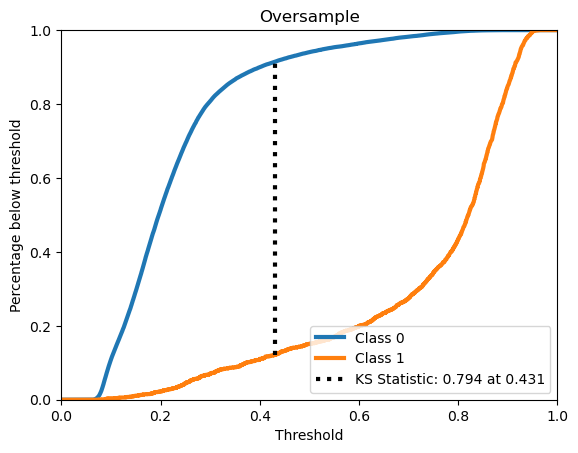

In [32]:
skplt.metrics.plot_ks_statistic(y_test, rf_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [33]:
rf_under_cut_off = loc_under_rf
rf_over_cut_off = loc_over_rf
rf_over_y_pred_proba_class = np.where(rf_over_y_pred_proba[:, 1] > rf_under_cut_off, 1, 0)
rf_under_y_pred_proba_class = np.where(rf_under_y_pred_proba[:, 1] > rf_over_cut_off, 1, 0)

### Precision-Recall Curve

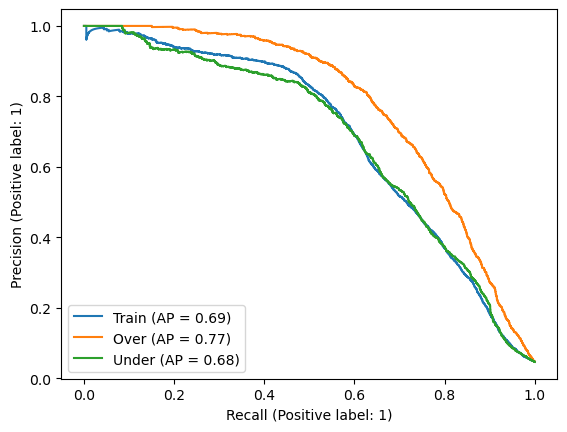

In [34]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

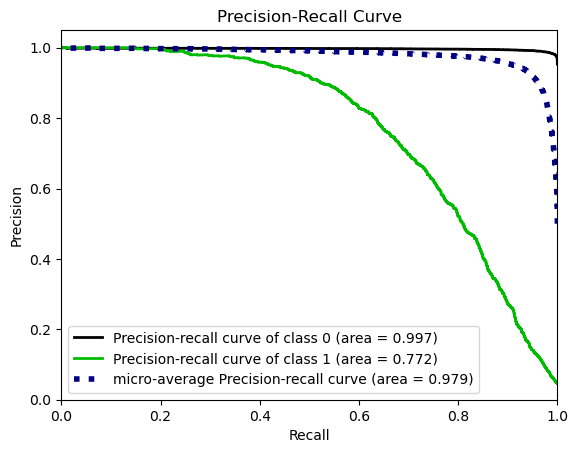

In [35]:
skplt.metrics.plot_precision_recall(y_test, rf_over_y_pred_proba)

### Confussion matrix

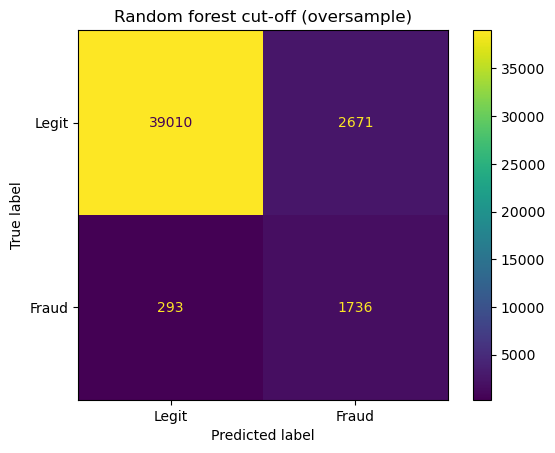

In [36]:
rf_cm_over = confusion_matrix(y_test, rf_over_y_pred_proba_class)
rf_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm_over, display_labels = ['Legit', 'Fraud'])
rf_cm_over_display.plot()
plt.title('Random forest cut-off (oversample)')
plt.show()

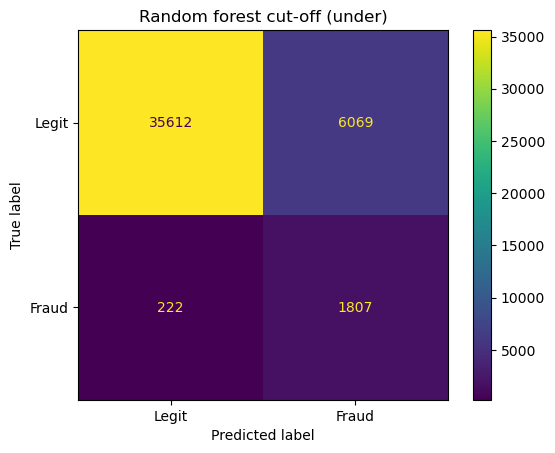

In [37]:
rf_cm_under = confusion_matrix(y_test, rf_under_y_pred_proba_class)
rf_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm_under, display_labels = ['Legit', 'Fraud'])
rf_cm_under_display.plot()
plt.title('Random forest cut-off (under)')
plt.show()

In [38]:
fn_cnt.append((rf_cm_under[1][0]))
fn_cnt.append((rf_cm_over[1][0]))

### Cumulative Gain

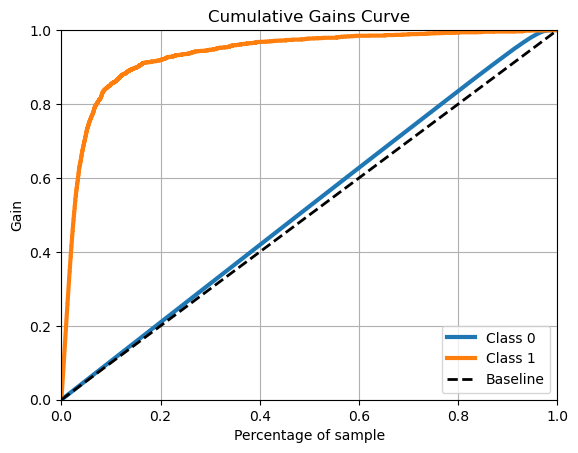

In [39]:
skplt.metrics.plot_cumulative_gain(y_test, rf_over_y_pred_proba)
plt.show()

### ROC

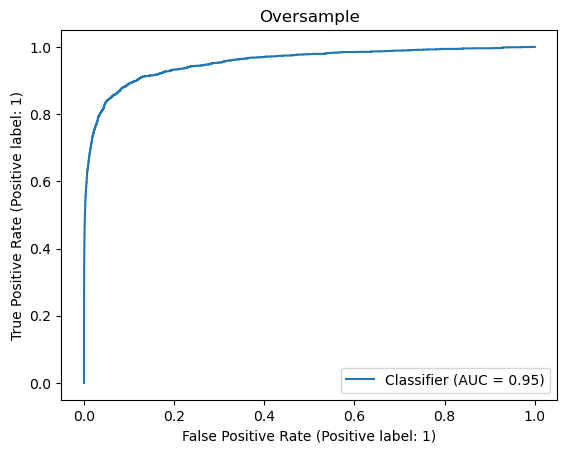

In [40]:
RocCurveDisplay.from_predictions(
    y_test, rf_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [41]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, rf_over_y_pred_proba_class)}')

Accuracy Train: 0.9345020982860729 Test: 0.9321894303363075


In [42]:
print(classification_report(y_test, rf_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     41681
           1       0.39      0.86      0.54      2029

    accuracy                           0.93     43710
   macro avg       0.69      0.90      0.75     43710
weighted avg       0.96      0.93      0.94     43710



In [43]:
print(f'The missclasification rate is: {missclassification_rate(y_test, rf_over_y_pred)}')

The missclasification rate is: 0.06387554335392359


### Example of tree from random forest

In [44]:
features = u_rf.best_estimator_[1].transformers_[0][1].get_feature_names_out().tolist()
features.extend(u_rf.best_estimator_[1].transformers_[1][1].get_feature_names_out().tolist())
export_graphviz(u_rf.best_estimator_[2].estimators_[1], out_file='img/tree.dot',rounded=True, precision=2, proportion=False, filled=True,feature_names=features )

# XGBoosting

In [45]:
with open('models/under_xgb.pkl', 'rb') as f:
    u_xgb = pickle.load(f)
f.close()

with open('models/over_xgb.pkl', 'rb') as f:
    o_xgb = pickle.load(f)
f.close()

### Predictions

In [46]:
xgb_under_y_pred = u_xgb.predict(X_test)
xgb_over_y_pred = o_xgb.predict(X_test)

xgb_under_y_pred_proba = u_xgb.predict_proba(X_test)
xgb_over_y_pred_proba =o_xgb.predict_proba(X_test)

under_train_pred = u_xgb.predict(X_train)
over_train_pred = o_xgb.predict(X_train)
under_train_pred_proba = u_xgb.predict_proba(X_train)
over_train_pred_proba = o_xgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. T

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_7545/1107856252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


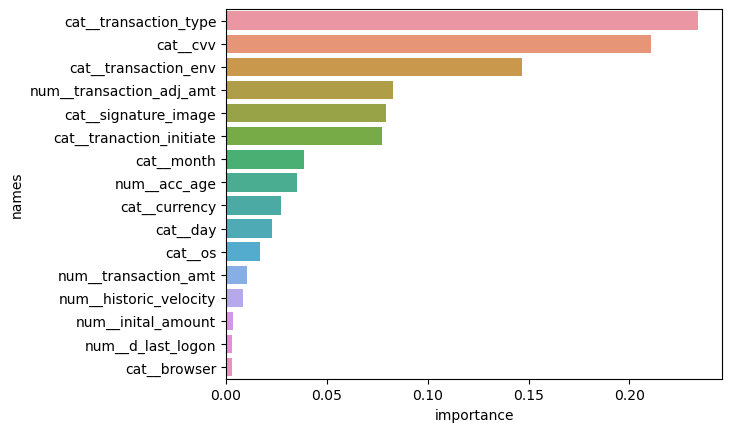

                       names  importance
9      cat__transaction_type    0.234170
2                   cat__cvv    0.210692
8       cat__transaction_env    0.146627
14  num__transaction_adj_amt    0.082908
6       cat__signature_image    0.079229
7   cat__tranaction_initiate    0.077457
4                 cat__month    0.038723
10              num__acc_age    0.035129
1              cat__currency    0.027209
3                   cat__day    0.022782
5                    cat__os    0.016775
15      num__transaction_amt    0.010572
12    num__historic_velocity    0.008279
13        num__inital_amount    0.003513
11         num__d_last_logon    0.003208
0               cat__browser    0.002725


In [47]:
importances = list(u_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(u_xgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_7545/1966249323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


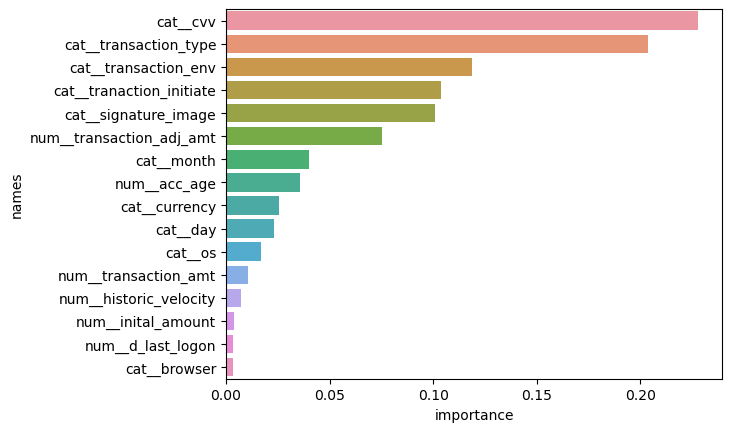

                       names  importance
2                   cat__cvv    0.228076
9      cat__transaction_type    0.203591
8       cat__transaction_env    0.118882
7   cat__tranaction_initiate    0.103780
6       cat__signature_image    0.100782
14  num__transaction_adj_amt    0.075338
4                 cat__month    0.039915
10              num__acc_age    0.035744
1              cat__currency    0.025620
3                   cat__day    0.023237
5                    cat__os    0.016879
15      num__transaction_amt    0.010640
12    num__historic_velocity    0.007056
13        num__inital_amount    0.003620
11         num__d_last_logon    0.003603
0               cat__browser    0.003237


In [48]:
importances = list(o_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(o_xgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [49]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_under_xgb = ks.statistic_location
ks_result.append(ks.statistic)

0.8111 p-value: 0.000e+00 loc: 0.5429579019546509


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


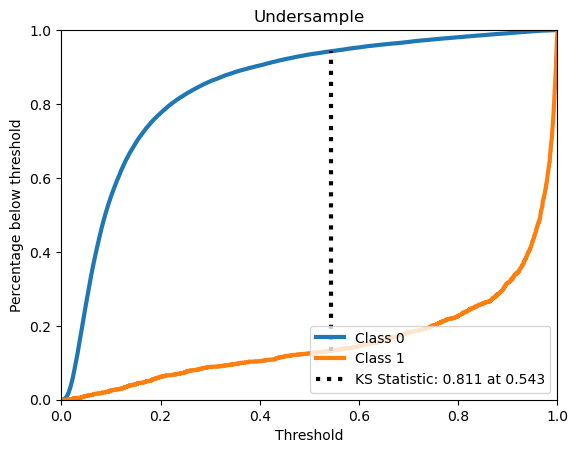

In [50]:
skplt.metrics.plot_ks_statistic(y_test, xgb_under_y_pred_proba, title='Undersample')
plt.show()

In [51]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_xgb = ks.statistic_location
ks_result.append(ks.statistic)

0.8201 p-value: 0.000e+00 loc: 0.5494405627250671


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


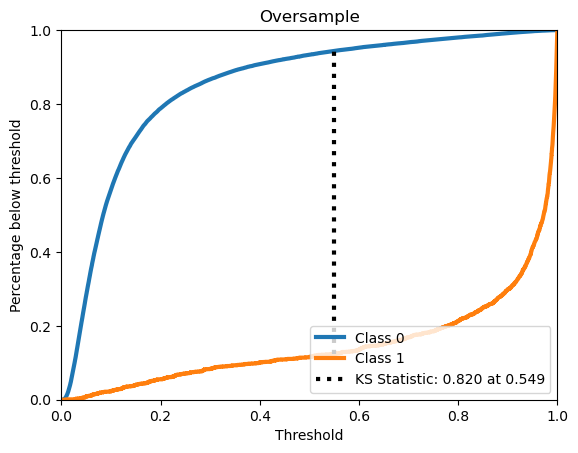

In [52]:
skplt.metrics.plot_ks_statistic(y_test, xgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [53]:
xgb_under_cut_off = loc_under_xgb
xgb_over_cut_off = loc_over_xgb
xgb_over_y_pred_proba_class = np.where(xgb_over_y_pred_proba[:, 1] > xgb_under_cut_off, 1, 0)
xgb_under_y_pred_proba_class = np.where(xgb_under_y_pred_proba[:, 1] > xgb_over_cut_off, 1, 0)

### Precision-Recall Curve

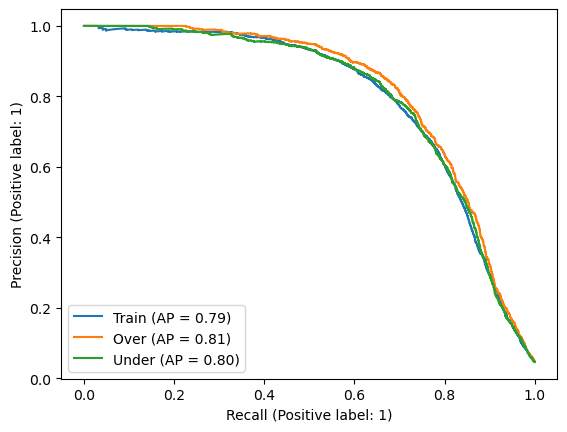

In [54]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

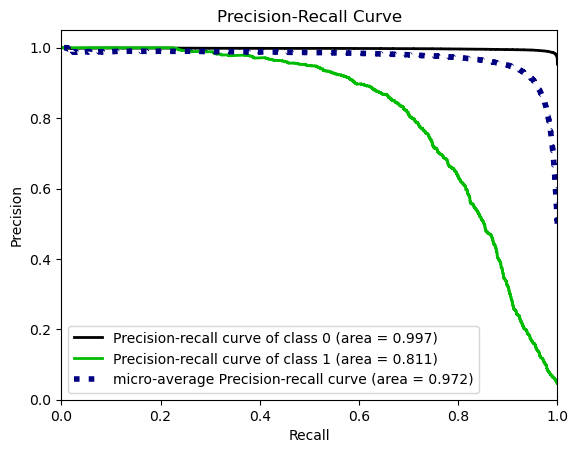

In [55]:
skplt.metrics.plot_precision_recall(y_test, xgb_over_y_pred_proba)

### Confussion matrix

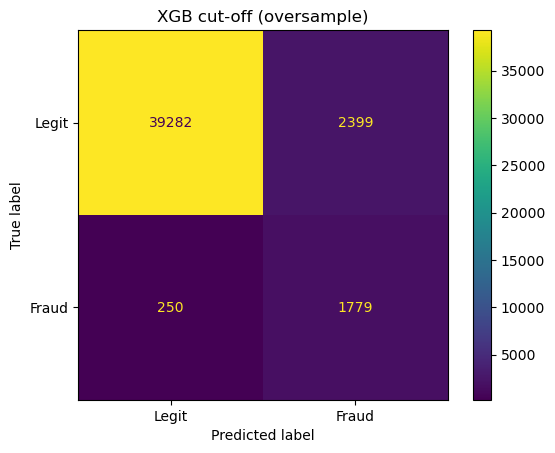

In [56]:
xgb_cm_over = confusion_matrix(y_test, xgb_over_y_pred_proba_class)
xgb_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_over, display_labels = ['Legit', 'Fraud'])
xgb_cm_over_display.plot()
plt.title('XGB cut-off (oversample)')
plt.show()

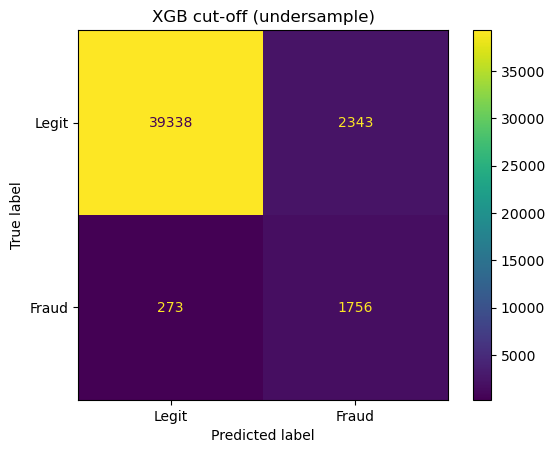

In [57]:
xgb_cm_under = confusion_matrix(y_test, xgb_under_y_pred_proba_class)
xgb_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_under, display_labels = ['Legit', 'Fraud'])
xgb_cm_under_display.plot()
plt.title('XGB cut-off (undersample)')
plt.show()

In [58]:
fn_cnt.append((xgb_cm_under[1][0]))
fn_cnt.append((xgb_cm_over[1][0]))

### Cumulative Gain

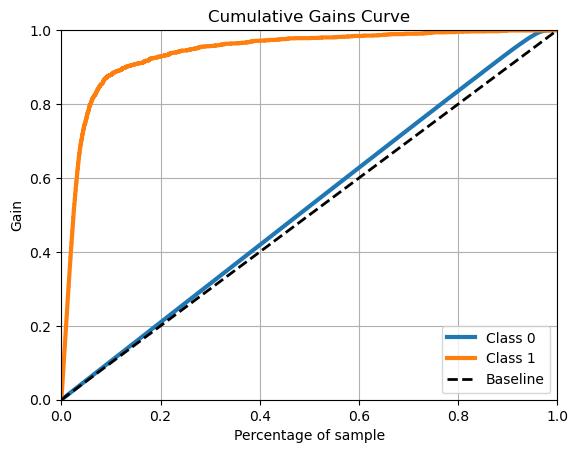

In [59]:
skplt.metrics.plot_cumulative_gain(y_test, xgb_over_y_pred_proba)
plt.show()

### ROC

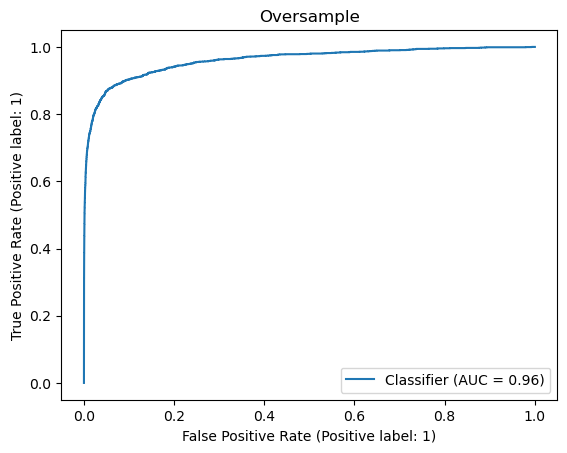

In [60]:
RocCurveDisplay.from_predictions(
    y_test, xgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [61]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, xgb_over_y_pred_proba_class)}')

Accuracy Train: 0.9287563242734439 Test: 0.9393960192175703


In [62]:
print(classification_report(y_test, xgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     41681
           1       0.43      0.88      0.57      2029

    accuracy                           0.94     43710
   macro avg       0.71      0.91      0.77     43710
weighted avg       0.97      0.94      0.95     43710



In [63]:
print(f'The missclasification rate is: {missclassification_rate(y_test, xgb_over_y_pred)}')

The missclasification rate is: 0.06902310684053992


# LGBoosting

In [64]:
with open('models/under_lgb.pkl', 'rb') as f:
    u_lgb = pickle.load(f)
f.close()

with open('models/over_lgb.pkl', 'rb') as f:
    o_lgb = pickle.load(f)
f.close()

### Predictions

In [65]:
lgb_under_y_pred = u_lgb.predict(X_test)
lgb_over_y_pred = o_lgb.predict(X_test)

lgb_under_y_pred_proba = u_lgb.predict_proba(X_test)
lgb_over_y_pred_proba =o_lgb.predict_proba(X_test)

under_train_pred = u_lgb.predict(X_train)
over_train_pred = o_lgb.predict(X_train)
under_train_pred_proba = u_lgb.predict_proba(X_train)
over_train_pred_proba = o_lgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. T

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_7545/1819173728.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


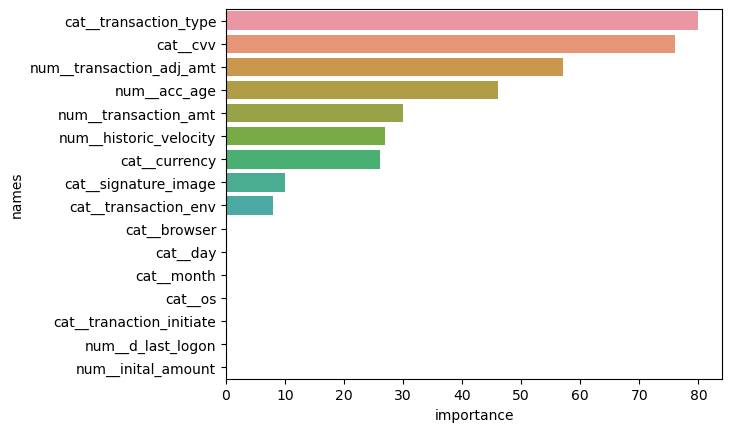

                       names  importance
9      cat__transaction_type          80
2                   cat__cvv          76
14  num__transaction_adj_amt          57
10              num__acc_age          46
15      num__transaction_amt          30
12    num__historic_velocity          27
1              cat__currency          26
6       cat__signature_image          10
8       cat__transaction_env           8
0               cat__browser           0
3                   cat__day           0
4                 cat__month           0
5                    cat__os           0
7   cat__tranaction_initiate           0
11         num__d_last_logon           0
13        num__inital_amount           0


In [66]:
importances = list(u_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(u_lgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_7545/3948416697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


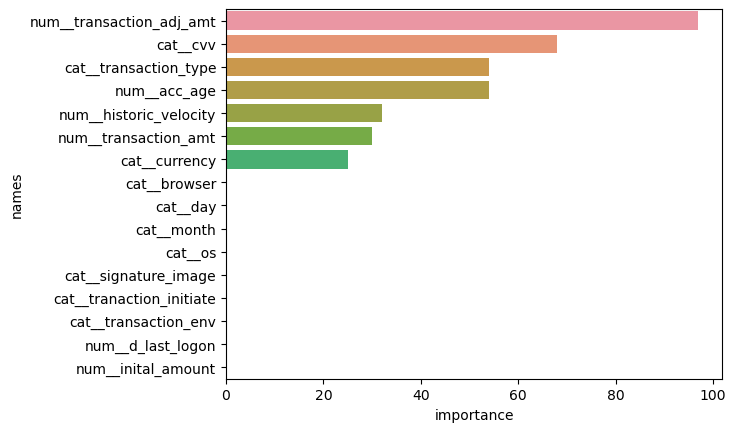

                       names  importance
14  num__transaction_adj_amt          97
2                   cat__cvv          68
9      cat__transaction_type          54
10              num__acc_age          54
12    num__historic_velocity          32
15      num__transaction_amt          30
1              cat__currency          25
0               cat__browser           0
3                   cat__day           0
4                 cat__month           0
5                    cat__os           0
6       cat__signature_image           0
7   cat__tranaction_initiate           0
8       cat__transaction_env           0
11         num__d_last_logon           0
13        num__inital_amount           0


In [67]:
importances = list(o_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(o_lgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [68]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_under_lgb = ks.statistic_location
ks_result.append(ks.statistic)

0.7386 p-value: 0.000e+00 loc: 0.49434297624526874


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


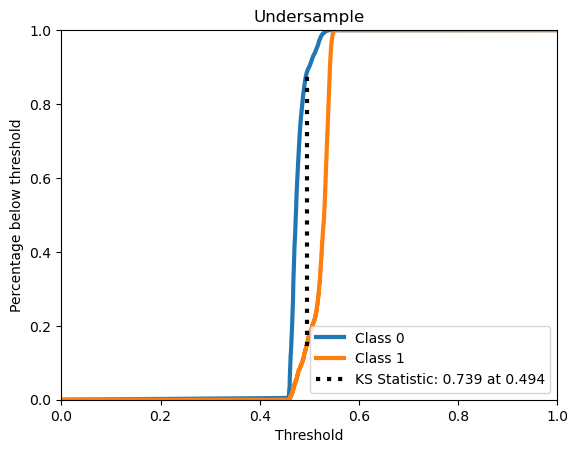

In [69]:
skplt.metrics.plot_ks_statistic(y_test, lgb_under_y_pred_proba, title='Undersample')
plt.show()

In [70]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_lgb = ks.statistic_location
ks_result.append(ks.statistic)

0.6957 p-value: 0.000e+00 loc: 0.47648684813891573


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


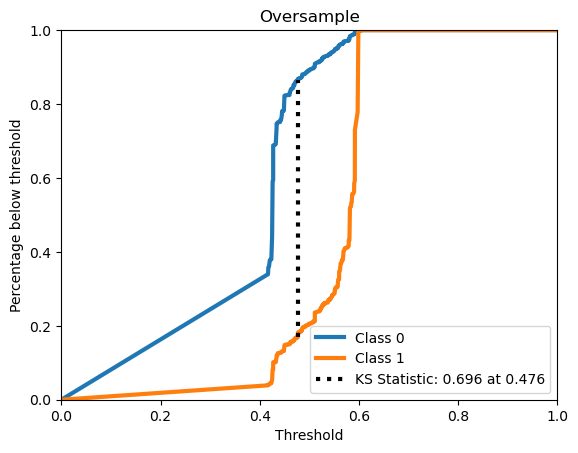

In [71]:
skplt.metrics.plot_ks_statistic(y_test, lgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [72]:
lgb_under_cut_off = loc_under_lgb
lgb_over_cut_off = loc_over_lgb
lgb_over_y_pred_proba_class = np.where(lgb_over_y_pred_proba[:, 1] > lgb_under_cut_off, 1, 0)
lgb_under_y_pred_proba_class = np.where(lgb_under_y_pred_proba[:, 1] > lgb_over_cut_off, 1, 0)

### Precision-Recall Curve

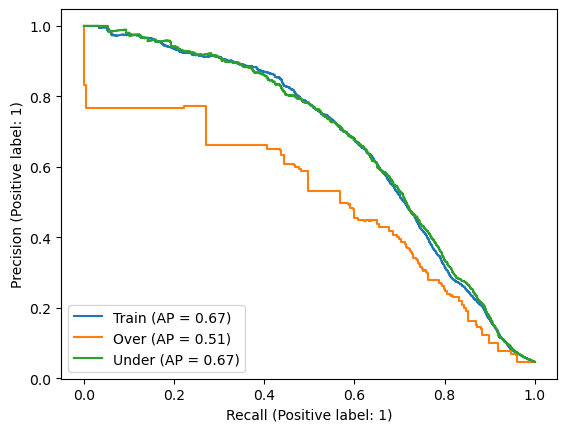

In [73]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

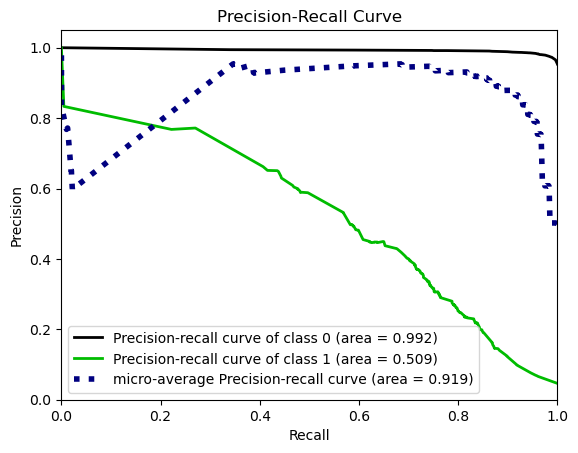

In [74]:
skplt.metrics.plot_precision_recall(y_test, lgb_over_y_pred_proba)

### Confussion matrix

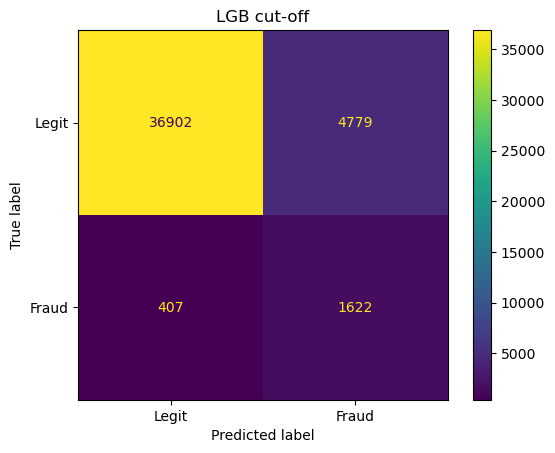

In [75]:
lgb_cm_over = confusion_matrix(y_test, lgb_over_y_pred_proba_class)
lgb_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm_over, display_labels = ['Legit', 'Fraud'])
lgb_cm_over_display.plot()
plt.title('LGB cut-off')
plt.show()

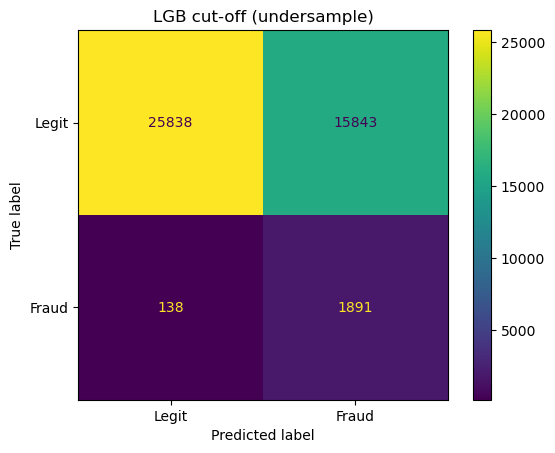

In [76]:
lgb_cm_under = confusion_matrix(y_test, lgb_under_y_pred_proba_class)
lgb_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm_under, display_labels = ['Legit', 'Fraud'])
lgb_cm_under_display.plot()
plt.title('LGB cut-off (undersample)')
plt.show()

In [77]:
fn_cnt.append((lgb_cm_under[1][0]))
fn_cnt.append((lgb_cm_over[1][0]))

### Cumulative Gain

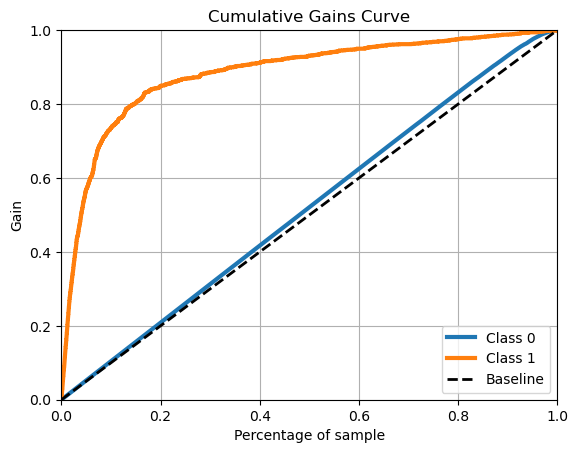

In [78]:
skplt.metrics.plot_cumulative_gain(y_test, lgb_over_y_pred_proba)
plt.show()

### ROC

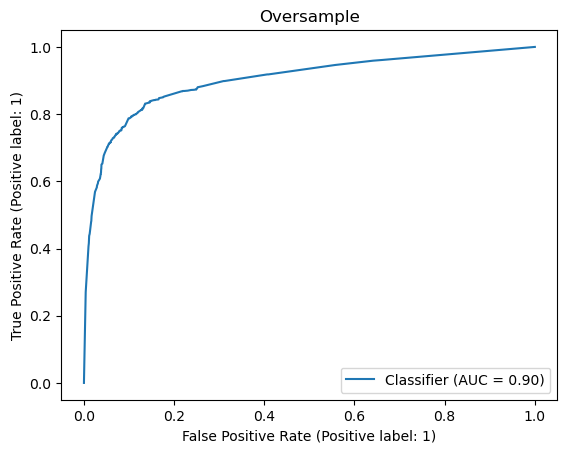

In [79]:
RocCurveDisplay.from_predictions(
    y_test, lgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [80]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lgb_over_y_pred_proba_class)}')

Accuracy Train: 0.8845746558418638 Test: 0.8813543811484786


In [81]:
print(classification_report(y_test, lgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     41681
           1       0.25      0.80      0.38      2029

    accuracy                           0.88     43710
   macro avg       0.62      0.84      0.66     43710
weighted avg       0.95      0.88      0.91     43710



In [82]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lgb_over_y_pred)}')

The missclasification rate is: 0.1123541523678792


# Aggregated Results

In [83]:
# Logistic Regression
recall_result.append(recall_score(y_test, lr_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, lr_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, lr_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, lr_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, lr_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, lr_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, lr_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, lr_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, lr_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, lr_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, lr_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, lr_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, lr_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, lr_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, lr_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, lr_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, lr_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, lr_over_y_pred_proba_class)))

In [84]:
# Random Forest
recall_result.append(recall_score(y_test, rf_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, rf_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, rf_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, rf_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, rf_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, rf_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, rf_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, rf_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, rf_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, rf_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, rf_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, rf_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, rf_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, rf_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, rf_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, rf_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, rf_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, rf_over_y_pred_proba_class)))

In [85]:
# XGB
recall_result.append(recall_score(y_test, xgb_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, xgb_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, xgb_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, xgb_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, xgb_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, xgb_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, xgb_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, xgb_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, xgb_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, xgb_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, xgb_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, xgb_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, xgb_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, xgb_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, xgb_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, xgb_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, xgb_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, xgb_over_y_pred_proba_class)))

In [86]:
# LGB
recall_result.append(recall_score(y_test, lgb_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, lgb_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, lgb_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, lgb_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, lgb_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, lgb_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, lgb_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, lgb_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, lgb_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, lgb_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, lgb_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, lgb_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, lgb_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, lgb_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, lgb_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, lgb_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, lgb_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, lgb_over_y_pred_proba_class)))

In [87]:
wyniki = pd.DataFrame(
    {'Model': model_name_result,'Recall': recall_result, 'Precision':precision_result,'F1': f1_result,
    'Accuracy': acc_result, 'KS' : ks_result, 'ROC_AUC': roc_auc_result,'PR_AUC': pr_auc_result,
    'Missclassification_rate': miss_rate_result, 'Acc_diff': acc_diff_result,'Recall_diff': recall_diff_result, 'False_negatives': fn_cnt}
    )


In [88]:
wyniki

,Model,Recall,Precision,F1,Accuracy,KS,ROC_AUC,PR_AUC,Missclassification_rate,Acc_diff,Recall_diff,False_negatives
0,Logistic Regression (undersample),0.841301,0.340447,0.484737,0.916976,0.764076,0.931101,0.733250,0.083024,0.022076,0.023811,322
1,Logistic Regression (oversample),0.855101,0.318465,0.464090,0.908328,0.770839,0.932328,0.738740,0.091672,0.023753,0.054721,294
2,Random forest (undersample),0.890586,0.229431,0.364866,0.856074,0.759387,0.930311,0.679477,0.143926,0.038825,0.073096,222
3,Random forest (oversample),0.855594,0.393919,0.539466,0.932189,0.793587,0.954649,0.771864,0.067811,0.047615,0.055214,293
4,XGB (undersample),0.865451,0.428397,0.573107,0.940151,0.811116,0.957543,0.796131,0.059849,0.045252,0.047960,273
5,XGB (oversample),0.876787,0.425802,0.573224,0.939396,0.820081,0.961306,0.811351,0.060604,0.054821,0.076406,250
6,LGB (undersample),0.931986,0.106631,0.191368,0.634386,0.738621,0.924815,0.670525,0.365614,0.260514,0.114496,138
7,LGB (oversample),0.799409,0.253398,0.384816,0.881354,0.695675,0.902464,0.508653,0.118646,0.003220,0.000972,407


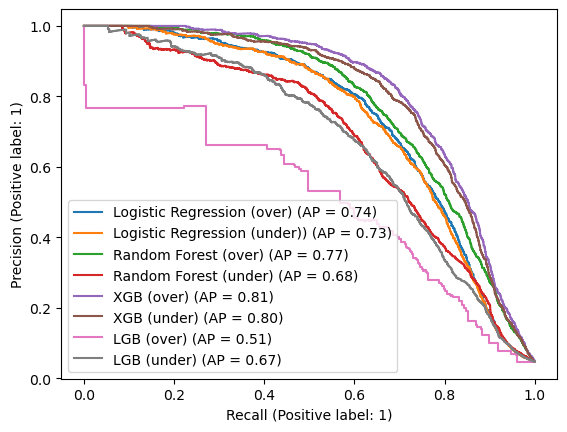

In [93]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name= "Logistic Regression (over)")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Logistic Regression (under))")

PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name= "Random Forest (over)")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Random Forest (under)")

PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name= "XGB (over)")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="XGB (under)")

PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name= "LGB (over)")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="LGB (under)")
plt.savefig("img/pr_result.png")
plt.show()

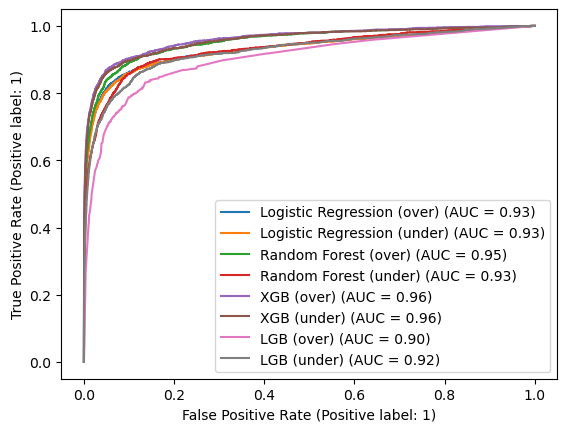

In [90]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name= 'Logistic Regression (over)')
RocCurveDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name='Logistic Regression (under)')

RocCurveDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name= 'Random Forest (over)')
RocCurveDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name='Random Forest (under)')

RocCurveDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name= 'XGB (over)')
RocCurveDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name='XGB (under)')

RocCurveDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name= 'LGB (over)')
RocCurveDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name='LGB (under)')
plt.show()

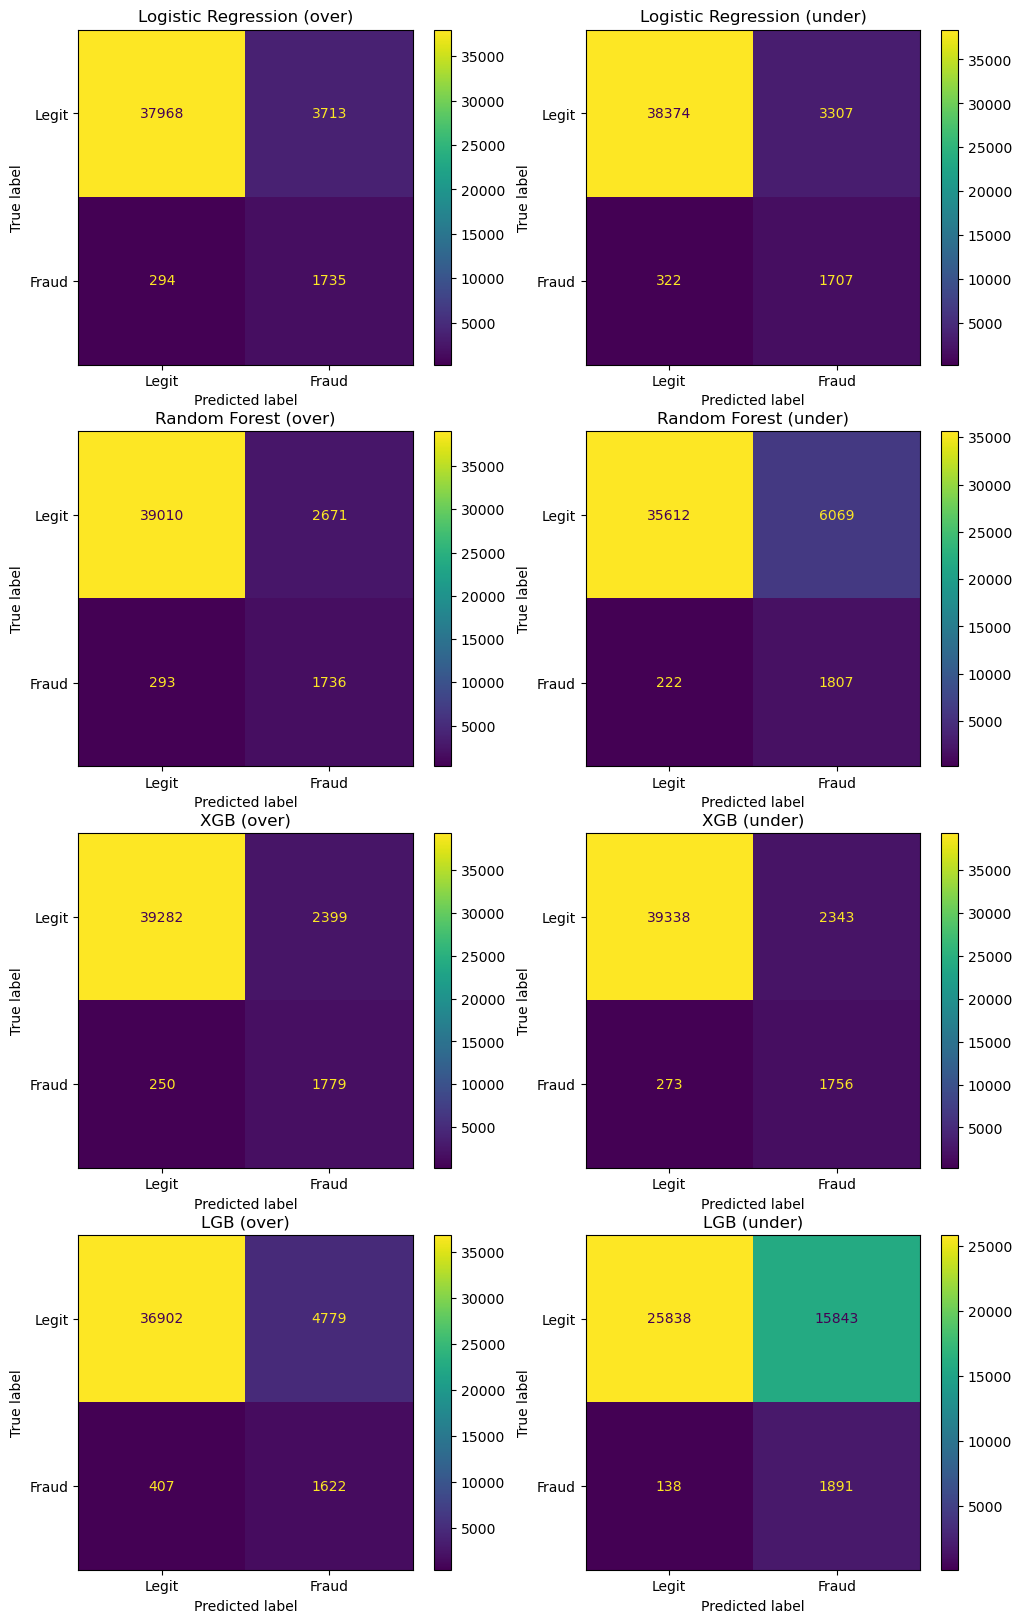

In [91]:
fig, axs = plt.subplots(4, 2, figsize=(12, 20))
lr_cm_over_display.plot(ax=axs[0][0])
axs[0][0].set_title('Logistic Regression (over)')
rf_cm_over_display.plot(ax=axs[1][0])
axs[1][0].set_title('Random Forest (over)')
xgb_cm_over_display.plot(ax=axs[2][0])
axs[2][0].set_title('XGB (over)')
lgb_cm_over_display.plot(ax=axs[3][0])
axs[3][0].set_title('LGB (over)')
lr_cm_under_display.plot(ax=axs[0][1])
axs[0][1].set_title('Logistic Regression (under)')
rf_cm_under_display.plot(ax=axs[1][1])
axs[1][1].set_title('Random Forest (under)')
xgb_cm_under_display.plot(ax=axs[2][1])
axs[2][1].set_title('XGB (under)')
lgb_cm_under_display.plot(ax=axs[3][1])
axs[3][1].set_title('LGB (under)')
plt.show()